
# Owl Detections — Plotting Notebook

This notebook loads the detections CSV produced by your YOLO pipeline and provides **separate cells** to produce useful plots for exploratory analysis and reporting.

**What you need to do first:**  
- Set the `CSV_PATH` variable below to point at your detections CSV.
- Run the **Setup** cell, then run each plot cell independently as needed.

The CSV is expected to have at least these columns:
- `site`, `station`, `timestamp`, `date`, `time`, `species`, `confidence`, `audio_path`, `segment_index`, `offset_seconds`, `image_path`.


In [41]:

# === Setup: edit this path to your CSV ===
CSV_PATH = r"F:\BirdData2025\detectionsyolo112025Final.csv"  # <-- change me

# Optional: filter dates (set to None to disable)
DATE_FROM = "2025-02-18"   # e.g., "2023-03-01"
DATE_TO   = "2025-03-19"   # e.g., "2023-07-31"

# Optional: restrict to certain species/sites (leave empty lists to include all)
FILTER_SPECIES = []   # e.g., ["Aegolius funereus", "Strix uralensis, Glaucidium passerinum"]
FILTER_SITES   = []   # e.g., ["HA", "KO", "RU"]

# ---------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load
df = pd.read_csv(CSV_PATH)

# Basic parsing & cleaning
def _parse_ts(row):
    ts = row.get("timestamp")
    if pd.notna(ts) and str(ts).strip() != "":
        return pd.to_datetime(ts, errors="coerce")
    d = row.get("date")
    t = row.get("time")
    if pd.notna(d) and pd.notna(t):
        return pd.to_datetime(f"{d} {t}", errors="coerce")
    if pd.notna(d):
        return pd.to_datetime(d, errors="coerce")
    return pd.NaT

if "timestamp" in df.columns:
    df["ts"] = df.apply(_parse_ts, axis=1)
else:
    if "date" in df.columns and "time" in df.columns:
        df["ts"] = pd.to_datetime(df["date"].astype(str) + " " + df["time"].astype(str), errors="coerce")
    elif "date" in df.columns:
        df["ts"] = pd.to_datetime(df["date"], errors="coerce")
    else:
        df["ts"] = pd.NaT

df = df.dropna(subset=["ts"]).copy()
df["date"] = df["ts"].dt.date.astype("string")
df["week"] = df["ts"].dt.to_period("W-SUN").apply(lambda p: p.start_time)
df["hour"] = df["ts"].dt.hour
df["dow"]  = df["ts"].dt.dayofweek

if DATE_FROM:
    df = df[df["ts"] >= pd.to_datetime(DATE_FROM)]
if DATE_TO:
    df = df[df["ts"] <= pd.to_datetime(DATE_TO)]
if FILTER_SPECIES:
    df = df[df["species"].isin(FILTER_SPECIES)]
if FILTER_SITES:
    df = df[df["site"].isin(FILTER_SITES)]

print("Loaded rows:", len(df))
print("Species:", sorted(df["species"].dropna().unique().tolist()))
print("Sites:", sorted(df["site"].dropna().unique().tolist()))


Loaded rows: 21880
Species: ['Aegolius Funereus', 'Glaucidium passerinum', 'Strix Uralensis']
Sites: ['Koti2', 'Tuohi1', 'Tuohi3', 'UPM11', 'UPM14', 'UPM21', 'UPM23', 'UPM25', 'Upm10', 'Upm12', 'Upm13', 'Upm22', 'Upm9']


## Daily Detection Timeline by Species

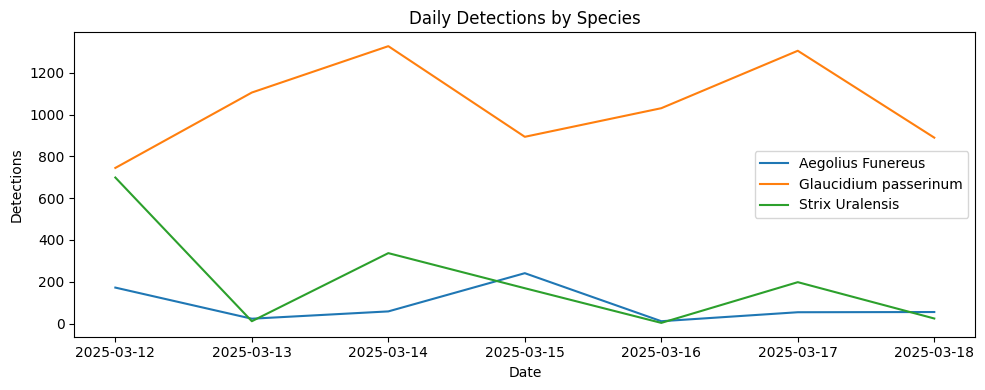

In [39]:
# Group by day + species
daily = df.groupby([df["ts"].dt.date, "species"]).size().rename("count").reset_index()

# Convert to datetime
daily["ts_date"] = pd.to_datetime(daily["ts"])

# Pivot
pivot_daily = daily.pivot_table(index="ts_date", columns="species", values="count", fill_value=0)

# ⏳ Restrict to Feb–Mar 2025
mask = (pivot_daily.index >= "2025-03-12") & (pivot_daily.index <= "2025-03-19")
pivot_daily = pivot_daily.loc[mask]

# Plot
plt.figure(figsize=(10, 4))
for col in pivot_daily.columns:
    plt.plot(pivot_daily.index, pivot_daily[col], label=str(col))

plt.title("Daily Detections by Species")
plt.xlabel("Date")
plt.ylabel("Detections")
plt.legend()
plt.tight_layout()
plt.show()


## Hourly Activity Patterns (0–23)

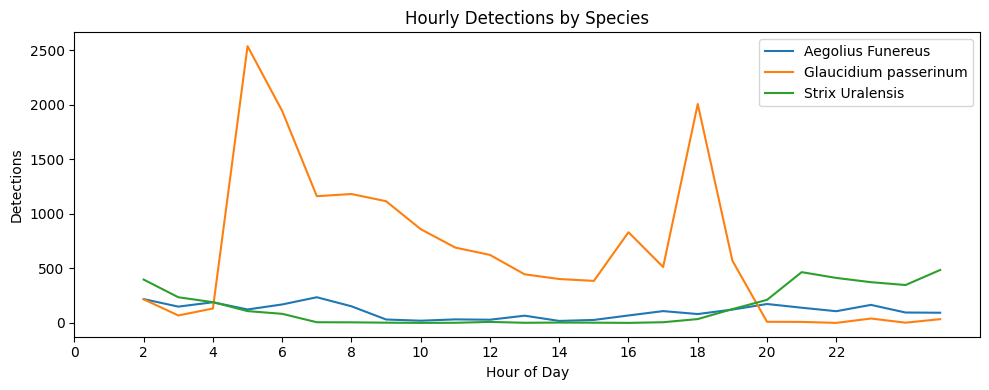

In [42]:

hourly = df.groupby(["hour", "species"]).size().rename("count").reset_index()
pivot_hourly = hourly.pivot_table(index="hour", columns="species", values="count", fill_value=0)

plt.figure(figsize=(10, 4))
for col in pivot_hourly.columns:
    plt.plot(pivot_hourly.index+2, pivot_hourly[col], label=str(col))
plt.title("Hourly Detections by Species")
plt.xlabel("Hour of Day")
plt.ylabel("Detections")
plt.xticks(range(0, 24, 2))
plt.legend()
plt.tight_layout()
plt.show()


## Day-of-Week Activity (0=Mon ... 6=Sun)

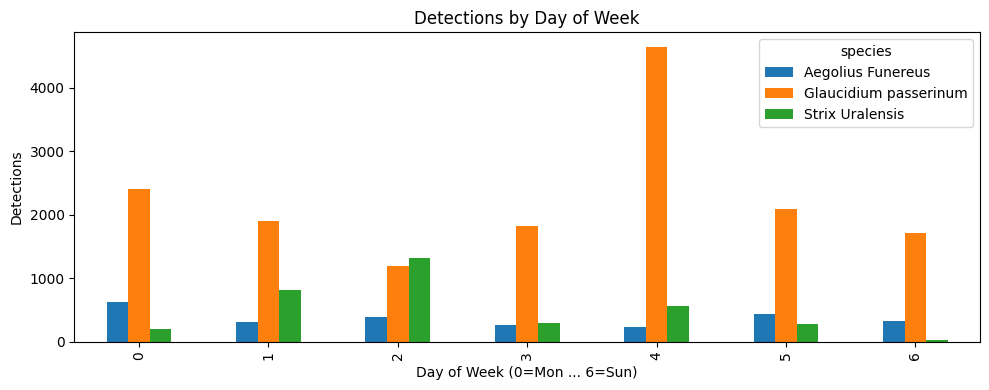

In [44]:

dow = df.groupby(["dow", "species"]).size().rename("count").reset_index()
pivot_dow = dow.pivot_table(index="dow", columns="species", values="count", fill_value=0)

ax = pivot_dow.plot(kind="bar", figsize=(10, 4))
ax.set_title("Detections by Day of Week")
ax.set_xlabel("Day of Week (0=Mon ... 6=Sun)")
ax.set_ylabel("Detections")
plt.tight_layout()
plt.show()


## Detections by Site (stacked by species)

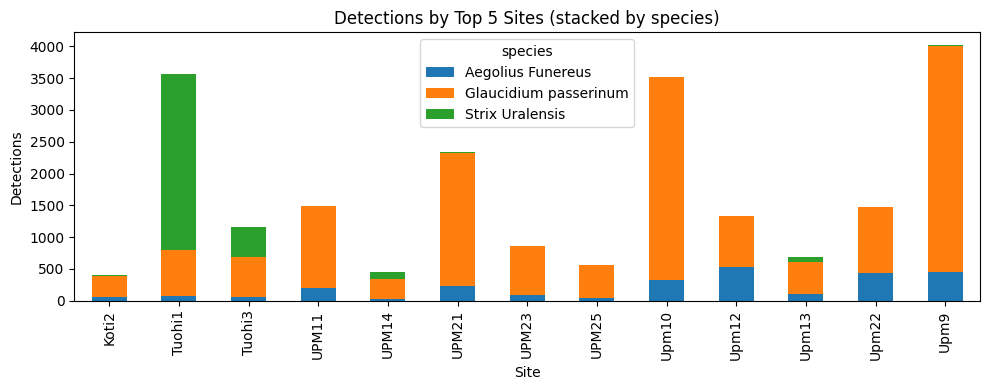

In [45]:
import matplotlib.pyplot as plt

# Group by site + species
site = df.groupby(["site", "species"]).size().rename("count").reset_index()

# Find top 5 sites by total detections
top_sites = (
    site.groupby("site")["count"].sum()
    .sort_values(ascending=False)
    .head(13)
    .index
)

# Filter to only those sites
site_top = site[site["site"].isin(top_sites)]

# Pivot for stacked bar
pivot_site = site_top.pivot_table(index="site", columns="species", values="count", fill_value=0)

# Plot
ax = pivot_site.plot(kind="bar", stacked=True, figsize=(10, 4))
ax.set_title("Detections by Top 5 Sites (stacked by species)")
ax.set_xlabel("Site")
ax.set_ylabel("Detections")
plt.tight_layout()
plt.show()
